In [1]:
import pandas as pd
df = pd.read_csv("run/accuracy/datasets/fever_with_evidence_5.csv")
df.columns

Index(['Unnamed: 0', 'label', 'claim', 'evidence_1', 'evidence_2',
       'evidence_3', 'evidence_4', 'gemma-2-2b-it', 'Mistral-7B-Instruct',
       'gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-270m-it',
       'Qwen/Qwen2.5-1.5B-Instruct', 'Qwen/Qwen2.5-3B-Instruct'],
      dtype='object')

In [2]:
len(df)

22682

In [3]:
df.loc[22681, 'label']

'REFUTES'

In [4]:
from typing import Any
import math

UNIQUE_LABELS = ["NOT ENOUGH INFO", "SUPPORTS", "REFUTES"]
NUM_TRIALS = 10
GAP = 1
ALPHA = 0.35
INDICES = list(range(len(df)))
MODELS = ['gemma-2-2b-it', 'Mistral-7B-Instruct',
       'gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-270m-it',
       'Qwen/Qwen2.5-1.5B-Instruct', 'Qwen/Qwen2.5-3B-Instruct']
NUM_LLMS = len(MODELS)
ACC = {}
for model in MODELS:
    ACC[model] =(df["label"] == df[model]).sum()
ACC

{'gemma-2-2b-it': 10259,
 'Mistral-7B-Instruct': 11892,
 'gemma-3-1b-it': 7974,
 'gemma-3-4b-it': 11277,
 'gemma-3-270m-it': 6683,
 'Qwen/Qwen2.5-1.5B-Instruct': 9332,
 'Qwen/Qwen2.5-3B-Instruct': 10955}

In [5]:

# unweighted voting
def most_votes_win(df) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += 1
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct
most_votes_win(df)

10433

In [6]:
def plot_weight_and_accuracy(weight_evolution: list[list[float]], models: list[str], accuracies: dict) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for model, weights in zip(models, per_model_weights):
        acc = accuracies[model]
        plt.plot(weights, label=f"{model} (acc={acc})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def mwu(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        minimax_load: int = NUM_LLMS + 1  # init above range
        best_index: int = len(df) # init out of range
        for index in index_range:
            row = df.iloc[index]
            votes = {label: 0. for label in UNIQUE_LABELS}
            for model_index, model in enumerate(MODELS):
                prediction = row[model]
                votes[prediction] += weights[model_index]
            # Find label with most votes
            winning_label = max(votes, key=votes.get)
            cur_max_load = votes[winning_label]
            # update best if current is better
            if cur_max_load < minimax_load:
                minimax_load = cur_max_load
                best_index = index

        # Update weights based on best_index
        best_row = df.iloc[best_index]
        for model_index, model in enumerate(MODELS):
            prediction = best_row[model]
            if prediction != best_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(best_index)
    return weight_evolution

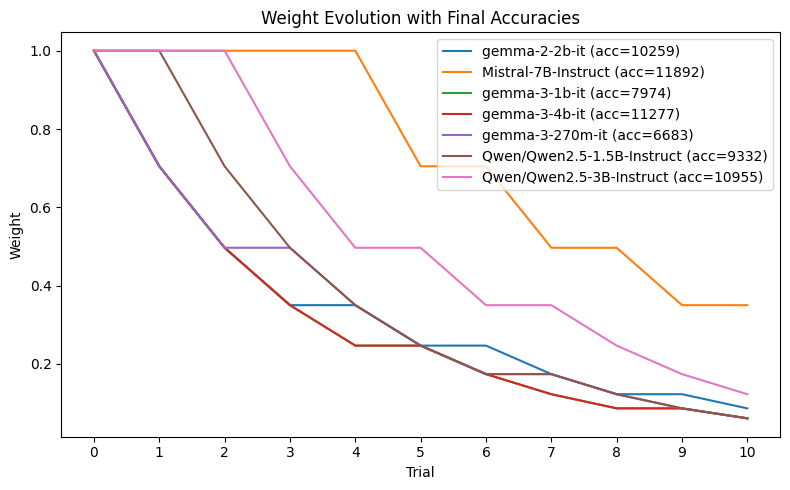

In [8]:
weight_evolution = mwu(df, INDICES.copy(), NUM_TRIALS, ALPHA)
plot_weight_and_accuracy(weight_evolution, MODELS, ACC)

In [11]:
weights = weight_evolution[-1]
final_weights: dict = {}
for model, weight in zip(MODELS, weights):
    final_weights[model] = weight
final_weights

{'gemma-2-2b-it': 0.08629358649937052,
 'Mistral-7B-Instruct': 0.3499377491111554,
 'gemma-3-1b-it': 0.06081006262521797,
 'gemma-3-4b-it': 0.06081006262521797,
 'gemma-3-270m-it': 0.06081006262521797,
 'Qwen/Qwen2.5-1.5B-Instruct': 0.06081006262521797,
 'Qwen/Qwen2.5-3B-Instruct': 0.12245642825298192}

In [12]:
# weighted voting 
def weighted_voting(df, wdict: dict[str, float]) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += wdict[model]
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct
weighted_voting(df, final_weights)

12139

In [15]:
import random

def mwu_random_samples(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        chosen_index = random.choice(index_range)

        # Update weights based on best_index
        chosen_row = df.iloc[chosen_index]
        for model_index, model in enumerate(MODELS):
            prediction = chosen_row[model]
            if prediction != chosen_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(chosen_index)
    return weight_evolution, weights

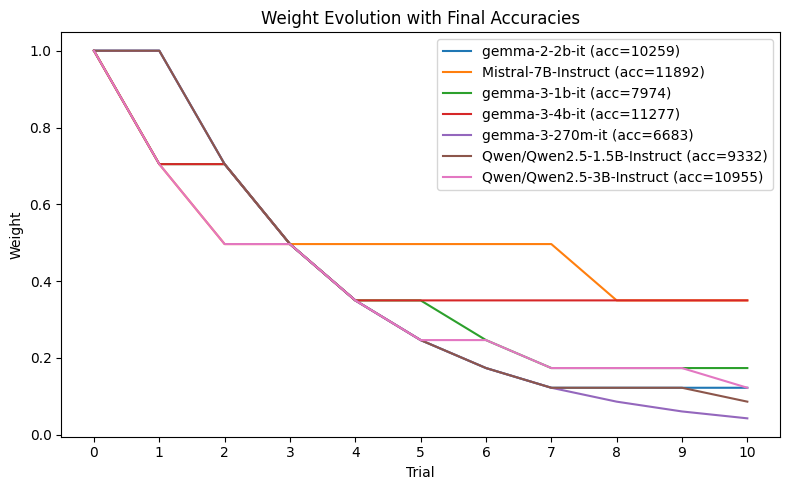

11610

In [16]:
weight_evolution_rand, final_weights_rand = mwu_random_samples(df, INDICES.copy(), NUM_TRIALS, ALPHA)
# final weights dict
wdict_rand = {}
for model, weight in zip(MODELS, final_weights_rand):
    wdict_rand[model] = weight

plot_weight_and_accuracy(weight_evolution_rand, MODELS, ACC)
weighted_voting(df, wdict_rand)

In [19]:
def mwu_variant(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, ) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        minimax_load: int = NUM_LLMS + 1  # init above range
        best_index: int = len(df) # init out of range
        for index in index_range:
            row = df.iloc[index]
            votes = {label: 0. for label in UNIQUE_LABELS}
            for model_index, model in enumerate(MODELS):
                prediction = row[model]
                votes[prediction] += 1 # changed line
                # votes[prediction] += weights[model_index] --- IGNORE ---
            # Find label with most votes
            winning_label = max(votes, key=votes.get)
            cur_max_load = votes[winning_label]
            # update best if current is better
            if cur_max_load < minimax_load:
                minimax_load = cur_max_load
                best_index = index

        # Update weights based on best_index
        best_row = df.iloc[best_index]
        for model_index, model in enumerate(MODELS):
            prediction = best_row[model]
            if prediction != best_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(best_index)
    return weight_evolution, weights

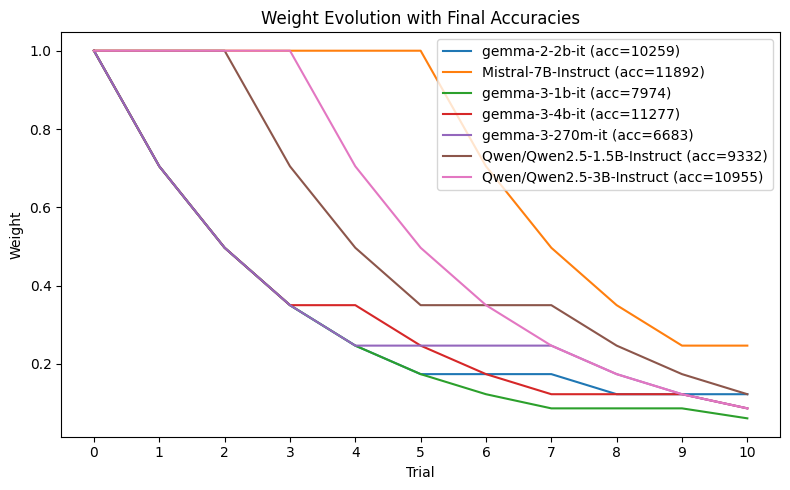

11624

In [20]:
weight_evolution_variant, final_weights_variant = mwu_variant(df, INDICES.copy(), NUM_TRIALS, ALPHA)
# final weights dict
wdict_variant = {}
for model, weight in zip(MODELS, final_weights_variant):
    wdict_variant[model] = weight

plot_weight_and_accuracy(weight_evolution_variant, MODELS, ACC)
weighted_voting(df, wdict_variant)